# Part 1: NER with CRF
- author: Hayley Song

In [43]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain

import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

import joblib
import eli5

from datetime import datetime

In [44]:
sys.path

['..',
 '..',
 '',
 '/home/hayley/miniconda3/envs/fastai/lib/python36.zip',
 '/home/hayley/miniconda3/envs/fastai/lib/python3.6',
 '/home/hayley/miniconda3/envs/fastai/lib/python3.6/lib-dynload',
 '/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages',
 '/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/defusedxml-0.5.0-py3.6.egg',
 '/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions',
 '/home/hayley/.ipython']

In [45]:
sys.path.insert(0, "..")

In [46]:
from nlp_utils import data_converter, conlleval

Load train data in IOB scheme and load train and dev data after changing it to the BIO scheme.

In [5]:
# train_data_iob = data_converter.read_conll('../data/eng.train')[1:] #ignore header
train_data_bio = data_converter.read_conll('../nlp_utils/train.bio')[1:] #ignore header
dev_data_bio = data_converter.read_conll('../nlp_utils/testa.bio')[1:]
test_data = data_converter.read_conll('../data/eng.testb')[1:]

In [6]:
# print(train_data_iob[0])
print("="*50)
print("train data")
print(train_data_bio[0])
print("="*50)
print("dev data")
print(dev_data_bio[0])
print("="*50)
print("test data")
print(test_data[0])

train data
[['EU', 'NNP', 'I-NP', 'I-ORG', 'B-ORG'], ['rejects', 'VBZ', 'I-VP', 'O', 'O'], ['German', 'JJ', 'I-NP', 'I-MISC', 'B-MISC'], ['call', 'NN', 'I-NP', 'O', 'O'], ['to', 'TO', 'I-VP', 'O', 'O'], ['boycott', 'VB', 'I-VP', 'O', 'O'], ['British', 'JJ', 'I-NP', 'I-MISC', 'B-MISC'], ['lamb', 'NN', 'I-NP', 'O', 'O'], ['.', '.', 'O', 'O', 'O']]
dev data
[['CRICKET', 'NNP', 'I-NP', 'O', 'O'], ['-', ':', 'O', 'O', 'O'], ['LEICESTERSHIRE', 'NNP', 'I-NP', 'I-ORG', 'B-ORG'], ['TAKE', 'NNP', 'I-NP', 'O', 'O'], ['OVER', 'IN', 'I-PP', 'O', 'O'], ['AT', 'NNP', 'I-NP', 'O', 'O'], ['TOP', 'NNP', 'I-NP', 'O', 'O'], ['AFTER', 'NNP', 'I-NP', 'O', 'O'], ['INNINGS', 'NNP', 'I-NP', 'O', 'O'], ['VICTORY', 'NN', 'I-NP', 'O', 'O'], ['.', '.', 'O', 'O', 'O']]
test data
[['SOCCER', 'NN', 'I-NP'], ['-', ':', 'O'], ['JAPAN', 'NNP', 'I-NP'], ['GET', 'VB', 'I-VP'], ['LUCKY', 'NNP', 'I-NP'], ['WIN', 'NNP', 'I-NP'], [',', ',', 'O'], ['CHINA', 'NNP', 'I-NP'], ['IN', 'IN', 'I-PP'], ['SURPRISE', 'DT', 'I-NP'], ['DE

Avg. sentence length: 13.651117784451118 words


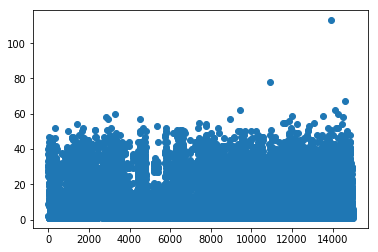

In [7]:
# sentence lengths
lengths = [len(sent) for sent in train_data_bio]
f, ax = plt.subplots()
ax.scatter(range(len(train_data_bio)), lengths)
print(f"Avg. sentence length: {np.mean(lengths)} words")

In [8]:
train_df_iob = pd.read_csv('../data/eng.train', delimiter=' ')
train_df = pd.read_csv('../data/train.bio', delimiter=' ')
dev_df = pd.read_csv('../data/testa.bio', delimiter=' ')

In [9]:
train_df.head()

,-DOCSTART-,-X-,O,O.1,O.2
0,EU,NNP,I-NP,I-ORG,B-ORG
1,rejects,VBZ,I-VP,O,O
2,German,JJ,I-NP,I-MISC,B-MISC
3,call,NN,I-NP,O,O
4,to,TO,I-VP,O,O


In [17]:
dev_df.head()

,-DOCSTART-,-X-,O,O.1,O.2
0,CRICKET,NNP,I-NP,O,O
1,-,:,O,O,O
2,LEICESTERSHIRE,NNP,I-NP,I-ORG,B-ORG
3,TAKE,NNP,I-NP,O,O
4,OVER,IN,I-PP,O,O


Change the column names to something more meaningful.

In [18]:
new_column = ['token', 'pos', 'chunk_tag', 'tag_ibo', 'tag_bio']
rename_dict = dict([kv for kv in zip(dev_df.columns, new_column)])
# do not to run this more than once (it will override the key values)
print(rename_dict)

{'-DOCSTART-': 'token', '-X-': 'pos', 'O': 'chunk_tag', 'O.1': 'tag_ibo', 'O.2': 'tag_bio'}


In [19]:
train_df.rename(rename_dict, axis='columns', inplace=True)
dev_df.rename(rename_dict, axis='columns', inplace=True)

In [20]:
print(train_df.head(10))
print("="*50)
print(dev_df.head(10))

     token  pos chunk_tag tag_ibo tag_bio
0       EU  NNP      I-NP   I-ORG   B-ORG
1  rejects  VBZ      I-VP       O       O
2   German   JJ      I-NP  I-MISC  B-MISC
3     call   NN      I-NP       O       O
4       to   TO      I-VP       O       O
5  boycott   VB      I-VP       O       O
6  British   JJ      I-NP  I-MISC  B-MISC
7     lamb   NN      I-NP       O       O
8        .    .         O       O       O
9    Peter  NNP      I-NP   I-PER   B-PER
            token  pos chunk_tag tag_ibo tag_bio
0         CRICKET  NNP      I-NP       O       O
1               -    :         O       O       O
2  LEICESTERSHIRE  NNP      I-NP   I-ORG   B-ORG
3            TAKE  NNP      I-NP       O       O
4            OVER   IN      I-PP       O       O
5              AT  NNP      I-NP       O       O
6             TOP  NNP      I-NP       O       O
7           AFTER  NNP      I-NP       O       O
8         INNINGS  NNP      I-NP       O       O
9         VICTORY   NN      I-NP       O       O

In [21]:
train_y = train_df['tag_bio']
dev_y = dev_df['tag_bio']

In [22]:
train_df.columns

Index(['token', 'pos', 'chunk_tag', 'tag_ibo', 'tag_bio'], dtype='object')

In [23]:
X = train_df[['token', 'pos']]
print(X.head())

     token  pos
0       EU  NNP
1  rejects  VBZ
2   German   JJ
3     call   NN
4       to   TO


## Word to individual feature
We represent a token/word as a feature vector using the following features:   
word in lowercase, POS, suffix2, suffix3, word shape info, prev_word in lowercase, prev_word_POS, prev_word_shape, next_word in lowercase, next_word_POS, next_word_shape,
location in the sentence (BOS, EOS)


## Improve features with context from neighboring words
Now, we use each word's vector representation to build a feature for each word using neighboring words.  
We will concatenate previous and next words' features to current word's features for the words in the middle of a sentence. If a word is at the sentence boundary (ie. beginning or end), then we add only the word features that is available.  We will also add two new boolean features, 'bos' and 'eos', that indicates whetehr the word is at the beginning or end of the sentence, repectively.

In [10]:
def wordInfo2vec(sent, i):
    """
    Make a vector representation of a wordInfo (tuple/list) at the ith position of the input sentence, sent.
    
    Args:
    - sent (list): a list of word information. 
    A word information is a list of [word, POS, chunk_tag, tag_ibo, tag_bio]
    - i (int): index into the sentence to select a word information
    
    Returns:
    - vec (list): a vector representation of the selected word using the following list of features.
    [word_lowercase, POS, POS2, last2, last3, isUpper, isTitle, isAlpha, isDigit]
    """
    assert(0 <= i and i < len(sent))
    word_info = sent[i]
    word, pos, *_ = word_info
#     print(f'word: {word}, pos: {pos}')
    
    vec = {
      'word': word.lower(),
      'pos': pos,
      'pos2': pos[:2],
      'last2': word[-2:],
      'last3': word[-3:],
      'isUpper': word.isupper(),
      'isTitle': word.istitle(),
      'isAlpha': word.isalpha(),
      'isDigit': word.isdigit(),
    }
    
          
    if len(sent) == 1:
        vec['bos'] = True
        vec['eos'] = True    
        return vec

    # add next word's context
    if i < len(sent)-1:          
        next_info = sent[i+1]
        next_word, next_pos, *_ = next_info
        vec.update({
            'next_word': next_word,
            'next_pos': next_pos,
            'next_pos2': next_pos[:2],
            'next_last2': next_word[-2:],
            'next_last3': next_word[-3:],
            'next_isUpper': next_word.isupper(),
            'next_isTitle': next_word.istitle(),
            'next_isalpha': next_word.isalpha(),
            'next_isdigit': next_word.isdigit()
        })
    else: 
        vec['eos'] = True

    # add previous word's context
    if i > 0:
        prev_info = sent[i-1]
        prev_word, prev_pos, *_ = prev_info
        vec.update({
            'prev_word': prev_word,
            'prev_pos': prev_pos,
            'prev_pos2': prev_pos[:2],
            'prev_last2': prev_word[-2:],
            'prev_last3': prev_word[-3:],
            'prev_isUpper': prev_word.isupper(),
            'prev_isTitle': prev_word.istitle(),
            'prev_isalpha': prev_word.isalpha(),
            'prev_isdigit': prev_word.isdigit()
        })
    else:
        vec['bos'] = True
      
    return vec

def test0_wordInfo2vec():
    wordInfo = train_data_bio[1][0]
    sent = [wordInfo]
    print(f"word info: {wordInfo}")
    print(f"vec: {wordInfo2vec(sent, 0)}")

def test_wordInfo2vec():
    sent = train_data_bio[1]
    for i in range(len(sent)):
        print("="*80)
        print(f"word info: {sent[i]}")
        vec = wordInfo2vec(sent, i)
        print(f"vec: {vec}")

test0_wordInfo2vec()
#test_wordInfo2vec()
    


word info: ['Peter', 'NNP', 'I-NP', 'I-PER', 'B-PER']
vec: {'word': 'peter', 'pos': 'NNP', 'pos2': 'NN', 'last2': 'er', 'last3': 'ter', 'isUpper': False, 'isTitle': True, 'isAlpha': True, 'isDigit': False, 'bos': True, 'eos': True}


In [11]:
def sent2vecs(sent):
    return [wordInfo2vec(sent, i) for i in range(len(sent))]

def test_sent2vecs():
    sent = train_data_bio[5]
    vecs = sent2vecs(sent)
    for vec in vecs:
        print("="*80)
        print(vec)
        
# test_sent2vecs();
    

{'word': '"', 'pos': '"', 'pos2': '"', 'last2': '"', 'last3': '"', 'isUpper': False, 'isTitle': False, 'isAlpha': False, 'isDigit': False, 'next_word': 'We', 'next_pos': 'PRP', 'next_pos2': 'PR', 'next_last2': 'We', 'next_last3': 'We', 'next_isUpper': False, 'next_isTitle': True, 'next_isalpha': True, 'next_isdigit': False, 'bos': True}
{'word': 'we', 'pos': 'PRP', 'pos2': 'PR', 'last2': 'We', 'last3': 'We', 'isUpper': False, 'isTitle': True, 'isAlpha': True, 'isDigit': False, 'next_word': 'do', 'next_pos': 'VBP', 'next_pos2': 'VB', 'next_last2': 'do', 'next_last3': 'do', 'next_isUpper': False, 'next_isTitle': False, 'next_isalpha': True, 'next_isdigit': False, 'prev_word': '"', 'prev_pos': '"', 'prev_pos2': '"', 'prev_last2': '"', 'prev_last3': '"', 'prev_isUpper': False, 'prev_isTitle': False, 'prev_isalpha': False, 'prev_isdigit': False}
{'word': 'do', 'pos': 'VBP', 'pos2': 'VB', 'last2': 'do', 'last3': 'do', 'isUpper': False, 'isTitle': False, 'isAlpha': True, 'isDigit': False, 'ne

In [12]:
def sent2labels(sent):
    """
    Create a list of lables for the sentence
    
    Args:
    - sent (list): a list of wordInfos
    """
    return [label for (*_, label) in sent]
def test_sent2labels():
    sent = train_data_bio[1]
    print(sent2labels(sent))
test_sent2labels()

['B-PER', 'I-PER']


## Create train, dev, test data matrix and labels

In [13]:
# Create datasets with these feature vectors for each word_info
X_train = [sent2vecs(sent) for sent in train_data_bio]
y_train = [sent2labels(sent) for sent in train_data_bio]

In [14]:
print("n_sentences: ",len(X_train))
print("n_words: ", len([1 for sent in X_train for w in sent]))
print("y_train len: ", len(y_train))
print (y_train[3])

n_sentences:  14985
n_words:  204562
y_train len:  14985
['O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [15]:
X_dev = [sent2vecs(sent) for sent in dev_data_bio]
y_dev = [sent2labels(sent) for sent in dev_data_bio]

In [16]:
X_test = [sent2vecs(sent) for sent in test_data]
# remember we need to convert the tags in BIO scheme to IBO scheme before submitting

## Train our first crf model

In [17]:
# Define our CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=1,
    all_possible_transitions=True
)

In [18]:
print (f"n_sentences: {np.array(X_train).shape[0]}")

n_sentences: 14985


In [19]:
%%time
crf.fit(X_train, y_train)

CPU times: user 9.18 s, sys: 455 ms, total: 9.63 s
Wall time: 10.9 s


CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=1,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

## Initial evaluation

We are interested in the entity-level evaluation, so let's exclude entity type 'O' from our evaluations.


In [20]:
labels = list(crf.classes_); print(labels)
labels.remove('O'); print(labels)

['B-ORG', 'O', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC']
['B-ORG', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC']


In [21]:
y_pred = crf.predict(X_dev)
metrics.flat_f1_score(y_dev, y_pred,
                      average='weighted', 
                      labels=labels)

/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

We can inspect performances per entity type

In [22]:
sorted_labels = sorted(labels, 
                       key=lambda name: name.split('-')[::-1]
                      )
print(sorted_labels)

['B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER']


In [23]:
print(metrics.flat_classification_report(
    y_dev, y_pred, labels=sorted_labels, digits=3
))

/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-LOC      0.000     0.000     0.000      1837
       I-LOC      0.000     0.000     0.000       257
      B-MISC      0.000     0.000     0.000       922
      I-MISC      0.000     0.000     0.000       346
       B-ORG      0.000     0.000     0.000      1340
       I-ORG      0.000     0.000     0.000       750
       B-PER      0.000     0.000     0.000      1842
       I-PER      0.000     0.000     0.000      1307

   micro avg      0.000     0.000     0.000      8601
   macro avg      0.000     0.000     0.000      8601
weighted avg      0.000     0.000     0.000      8601



In [24]:
eli5.show_weights(crf, top=30)

Let's save this trained model.

In [25]:
import joblib
def get_current_time():
    now = datetime.now()
    now_str = f"{now.strftime('%m')}_{now.strftime('%d')}_{now.strftime('%H')}_{now.strftime('%M')}"
    return now_str


In [40]:
joblib.dump(crf, f"../log/trained/crf_c1:0.1_c2:0.1_iter:100_{get_current_time()}.sav")

['../log/trained/crf_0.1_0.1_100iter_09_25_11_00.sav']

## Hyperparameter tuning 

In [88]:
# define fixed parameters and parameters to search
crf_rs = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=500, 
    all_possible_transitions=True
)
# params_space = {
#     'c1': scipy.stats.expon(scale=0.5),
#     'c2': scipy.stats.expon(scale=0.05),
# }

params_space = {
#     'c1': scipy.stats.truncnorm(-1,2,loc=3,scale=3), #first two are supports (as offsets from mean), loc is mean, scale is var
    'c1': scipy.stats.truncnorm(-1.5,2,loc=5,scale=3),
    'c2': scipy.stats.truncnorm(-1, 2 ,loc=2,scale=2)
}
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

In [89]:
%%time
# search

rs = RandomizedSearchCV(crf_rs, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=100, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 64.1min finished


CPU times: user 9min 40s, sys: 45.1 s, total: 10min 25s
Wall time: 1h 8min 5s


In [91]:
# Save this random search result
joblib.dump(rs, f'../log/trained/rs2_cv:3_niter:100_{get_current_time()}.sav')

['../log/trained/rs2_cv:3_niter:100_10_09_12_21.sav']

## Inspect random search space and performance

In [92]:
report = pd.DataFrame(rs.cv_results_)
c1s = report.param_c1
c2s = report.param_c2
scores = report.mean_test_score

/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

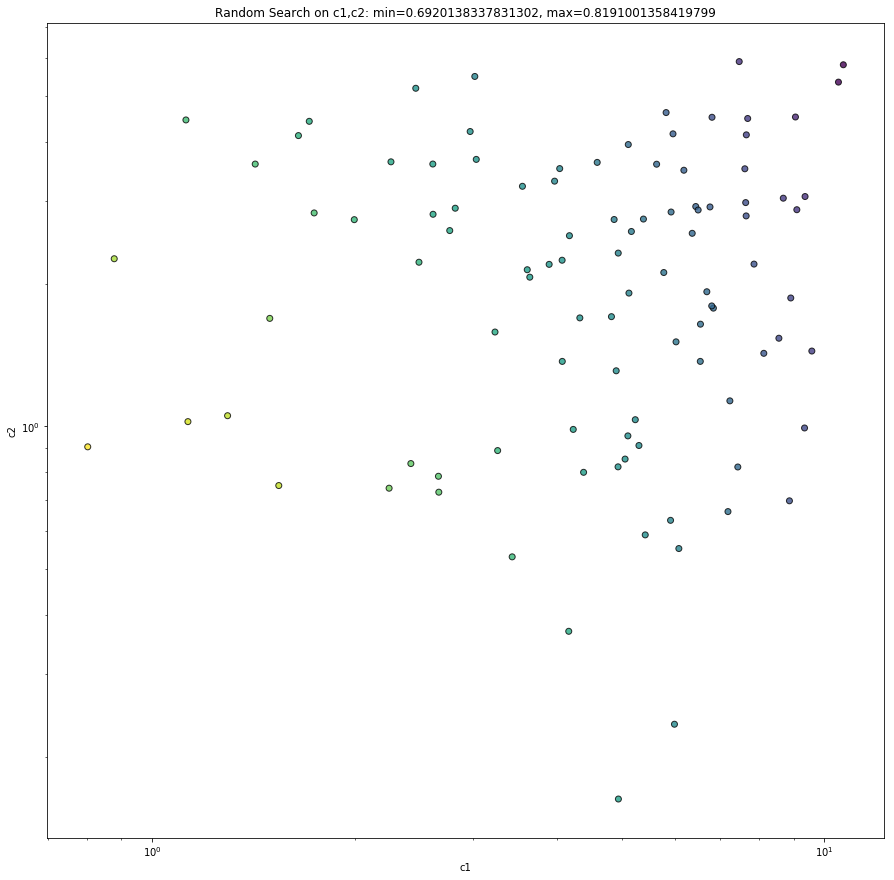

In [94]:
f,ax = plt.subplots(figsize=(15,15))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('c1')
ax.set_ylabel('c2')
ax.set_title(f'Random Search on c1,c2: min={min(scores)}, max={max(scores)}')
ax.scatter(c1s, c2s, c=scores, alpha=0.8, edgecolors=[0,0,0])
# plt.colorbar()

## Evaluation of the best CV model

In [95]:
crf_rs = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.8020282577136353, 'c2': 0.9056248251241479}
best CV score: 0.8191001358419799
model size: 0.96M


In [96]:
y_pred_rs = crf_rs.predict(X_dev)
print(metrics.flat_classification_report(
    y_dev, y_pred_rs, labels= sorted_labels, digits=3)
     )

              precision    recall  f1-score   support

       B-LOC      0.879     0.837     0.858      1837
       I-LOC      0.921     0.767     0.837       257
      B-MISC      0.901     0.809     0.853       922
      I-MISC      0.868     0.720     0.787       346
       B-ORG      0.841     0.769     0.803      1340
       I-ORG      0.788     0.789     0.789       750
       B-PER      0.881     0.890     0.885      1842
       I-PER      0.932     0.950     0.941      1307

   micro avg      0.877     0.841     0.859      8601
   macro avg      0.876     0.816     0.844      8601
weighted avg      0.877     0.841     0.858      8601



Comparing this result with the result from the initial, randomly guessed hyperparameter setting of c1=c2=0.1, we don't actually see a big improvement. Let's further inspect what the classifier learned then. In order to do so, we can inspect the learned transition (state to state, i.e label to label) probability distribution. In addition, we will inspect the probability of a state (ie. label) of this selected model.

In [97]:
# use eli5 for the model inspection
eli5.show_weights(crf_rs, top=50)

Let's first take a look at the learned transition matrix. The transition probabilities look reasonable as it shows high probabilities of transitioning from `B-TYPE` to `I-TYPE` (for instance, `B-MISC` to `I-MISC` and `B-ORG` to `I-ORG`.  Conversely, the model learned that it's unlikely to see a beginning tag of a type to be followed by an intermediate tag of a different type: Pr{`B_ORG` -> `t`} are either very close to 0 or negative for any `t` that is not `I-ORG`, and `B-PER` shows the same trend. 

In [226]:
eli5.show_weights(crf, top=30)

Unfortuntately, it looks like the CRF just remembering a lot of words. For example for the tag `B-per`, the algorithm remembers ‘president’ ‘obama’. To overcome this issue we can tune the paramters, especially the regularization paramters of the CRF algorithm. The $c_1$ and $c_2$ parameter of the CRF algorithm are the regularization parameters $\lambda_1$ and $\lambda_2$. While c1 weights the $l_{1}$ regularization, the $c_2 $parameter weights the $l_2$ regularization. We know limit the number of features used by enforcing sparsity on the parameter vector  $w$. To do this we increase the $l_1$ regularization parameter $c_1$.

## Regularization of the CRF model 

In [230]:
crf_reg = sklearn_crfsuite.CRF(algorithm='lbfgs',
          c1=10,
          c2=0.1,
          max_iterations=1000,
          all_possible_transitions=False)

In [36]:
# Save this model
joblib.dump(crf_reg, f'crf_c1:100_c2:0.1_{get_current_time()}.sav')

NameError: name 'crf_reg' is not defined

In [41]:
crf_reg = joblib.load('../log/trained/crf_c1:100_c2:0.1_09_26_01_27.sav')
reg_train_pred = cross_val_predict(estimator=crf_reg, X=X_train, y=y_train, cv=5)
report = metrics.flat_classification_report(y_pred=reg_train_pred, y_true=y_train)
print(report)

              precision    recall  f1-score   support

       B-LOC       0.76      0.76      0.76      7140
      B-MISC       0.84      0.63      0.72      3438
       B-ORG       0.71      0.63      0.67      6319
       B-PER       0.77      0.79      0.78      6600
       I-LOC       0.75      0.54      0.63      1157
      I-MISC       0.70      0.44      0.54      1155
       I-ORG       0.65      0.69      0.67      3704
       I-PER       0.82      0.91      0.86      4528
           O       0.98      0.99      0.99    170521

   micro avg       0.95      0.95      0.95    204562
   macro avg       0.78      0.71      0.74    204562
weighted avg       0.95      0.95      0.95    204562



In [42]:
%%time
# Train on the entire train data
crf_reg.fit(X_train, y_train)

CPU times: user 3min 57s, sys: 177 ms, total: 3min 57s
Wall time: 3min 57s


CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=False, averaging=None, c=None, c1=10, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=1000,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [73]:
# Visualize the weights
eli5.show_weights(crf_reg, top=30)

First of all, notice how setting the parameter $c_1$ for the $l_1$ regularizer drove many weights to be close to zero.  We can see that the regualization is doing the right job of making the weight parameters sparse. To see if this high regualization hyperparameter for $l_1$ term, we further inspect the transition probabilities and the learned weights. Let's focus on the second columns of Table 4 with Table 3. We discussed earlier that the unregularized model memorized specific words word-by-word for deciding whether to output `B-LOC` or not.  All the features with high weights were given to tokens learned from the training dataset, such as "chester-le-street", "gemerny" and "hungary". However, this overfitting is alleviated through increasing the $l_1$ regualization. The regualized model assigns high weights to more generalizable features such as "bos" (i.e. beginning of the sentence), "prev_las2:AT" and "last2:ia". We observe this improvement in generalization for other class weights as well.  Column for `Y=I-ORG` shows high weights for features like `word:co`, `last3:oom`, `next_isDigit` and `word:corp` which are all intuitively reasonable (for instance a lot of companies name starts with `Cooporation...`) and not specific to a single training instance, like "Microsoft". For `I-PER` class, the most significant weights were assigned to features like `last2:er`, `last2:on`, `prev_isUpper` and `pos:NNP`.  These features in fact match the rules how a human would decide whether an entity is of PERSON.  

## Part 1 prediction
Now, we make a prediction on the `testb` dataset using this tuned, regulaized CRF model.

In [44]:
# Predict X_dev
reg_dev_pred = crf_reg.predict(X_dev)

# Evaluate using precision, recall and F-1
print(metrics.flat_classification_report(
     y_dev, reg_dev_pred, labels= sorted_labels, digits=3)
     )

              precision    recall  f1-score   support

       B-LOC      0.793     0.763     0.778      1837
       I-LOC      0.797     0.564     0.661       257
      B-MISC      0.859     0.682     0.761       922
      I-MISC      0.773     0.454     0.572       346
       B-ORG      0.734     0.647     0.688      1340
       I-ORG      0.618     0.649     0.633       750
       B-PER      0.809     0.840     0.825      1842
       I-PER      0.873     0.921     0.897      1307

   micro avg      0.790     0.749     0.769      8601
   macro avg      0.782     0.690     0.727      8601
weighted avg      0.791     0.749     0.766      8601



In [98]:
# Predict on test
crf_reg = crf_rs
reg_test_pred_bio = crf_reg.predict(X_test)
reg_test_pred_ibo = data_converter.tags_to_conll(reg_test_pred_bio)

In [100]:
joblib.dump(reg_test_pred_bio,'../report/predictions/crf_rs_bio.sav')

['../report/predictions/crf_rs_bio.sav']

## Processing our predictions for submission

In [108]:
t = reg_test_pred_bio[96]
t2 = data_converter.tags_to_conll(t)

In [110]:
print(reg_test_pred_bio[96])
print(reg_test_pred_ibo[96])


['O', 'O', 'I-LOC', 'I-LOC', 'B-LOC', 'I-LOC', 'O', 'O', 'O']
['O', 'O', 'I-LOC', 'I-LOC', 'B-LOC', 'I-LOC', 'O', 'O', 'O']


In [106]:
print(t2)

['O', 'O', 'O', 'I-LOC', 'O', 'I-LOC', 'I-LOC', 'O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [107]:
import pdb
for i,tags in enumerate(reg_test_pred_bio):
    for t in tags:
        if 'B' in t:
            print(i)
            print(tags)
            pdb.set_trace()

96
['O', 'O', 'I-LOC', 'I-LOC', 'B-LOC', 'I-LOC', 'O', 'O', 'O']
> <ipython-input-107-2a21800d1e6c>(3)<module>()
-> for t in tags:


(Pdb)  q


BdbQuit: 

In [111]:
print("Number of test sentences: ", len(test_data))
print("sanity check: ", len(reg_test_pred_ibo))
print(len(reg_test_pred_ibo[0]))
print(reg_test_pred_ibo[0])

Number of test sentences:  3683
sanity check:  3683
12
['O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'I-LOC', 'O', 'O', 'O', 'O']


In [112]:
test_sent0 = test_data[0]
print(len(test_sent0))
print(test_sent0)

12
[['SOCCER', 'NN', 'I-NP'], ['-', ':', 'O'], ['JAPAN', 'NNP', 'I-NP'], ['GET', 'VB', 'I-VP'], ['LUCKY', 'NNP', 'I-NP'], ['WIN', 'NNP', 'I-NP'], [',', ',', 'O'], ['CHINA', 'NNP', 'I-NP'], ['IN', 'IN', 'I-PP'], ['SURPRISE', 'DT', 'I-NP'], ['DEFEAT', 'NN', 'I-NP'], ['.', '.', 'O']]


In [117]:
data_converter.add_column([test_sent0], [reg_test_pred_ibo[0]])

[[['SOCCER', 'NN', 'I-NP', 'O'],
  ['-', ':', 'O', 'O'],
  ['JAPAN', 'NNP', 'I-NP', 'I-LOC'],
  ['GET', 'VB', 'I-VP', 'O'],
  ['LUCKY', 'NNP', 'I-NP', 'O'],
  ['WIN', 'NNP', 'I-NP', 'O'],
  [',', ',', 'O', 'O'],
  ['CHINA', 'NNP', 'I-NP', 'I-LOC'],
  ['IN', 'IN', 'I-PP', 'O'],
  ['SURPRISE', 'DT', 'I-NP', 'O'],
  ['DEFEAT', 'NN', 'I-NP', 'O'],
  ['.', '.', 'O', 'O']]]

In [118]:
# Let's add the predicted labels for all words
augmented = data_converter.add_column(test_data, reg_test_pred_ibo)
print("Sanity check: ", len(augmented))
augmented[0]

Sanity check:  3683


[['SOCCER', 'NN', 'I-NP', 'O'],
 ['-', ':', 'O', 'O'],
 ['JAPAN', 'NNP', 'I-NP', 'I-LOC'],
 ['GET', 'VB', 'I-VP', 'O'],
 ['LUCKY', 'NNP', 'I-NP', 'O'],
 ['WIN', 'NNP', 'I-NP', 'O'],
 [',', ',', 'O', 'O'],
 ['CHINA', 'NNP', 'I-NP', 'I-LOC'],
 ['IN', 'IN', 'I-PP', 'O'],
 ['SURPRISE', 'DT', 'I-NP', 'O'],
 ['DEFEAT', 'NN', 'I-NP', 'O'],
 ['.', '.', 'O', 'O']]

In [119]:
# write to a file
_ = data_converter.conll_to_data_stream(augmented, write_to_file='./pred_crf_c1:0.8_c2:0.9.txt');